In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV,cross_val_score
import joblib
import mlflow
import optuna
import seaborn as sns
import xgboost as xgb# type: ignore

#importing the California Housing dataset from scikit-learn
california_housing = fetch_california_housing(data_home= 'W:/work/House_Price_Prediction/house-prediction-dataset',download_if_missing=True, as_frame=True)

df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)

df['MedHouseVal'] = california_housing.target

df.head()

df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


number of null values in the dataset:
 MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64
Number of na values in the dataset:
 MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


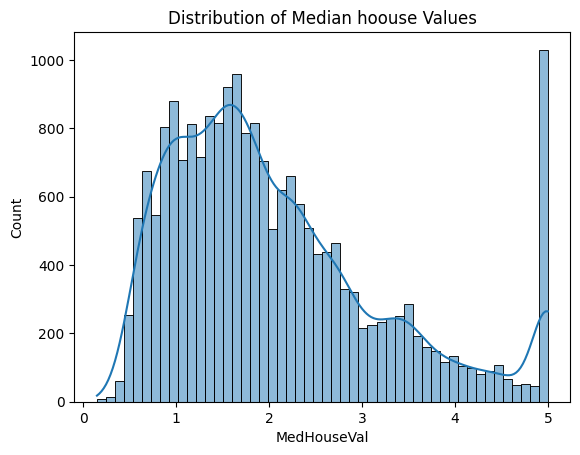

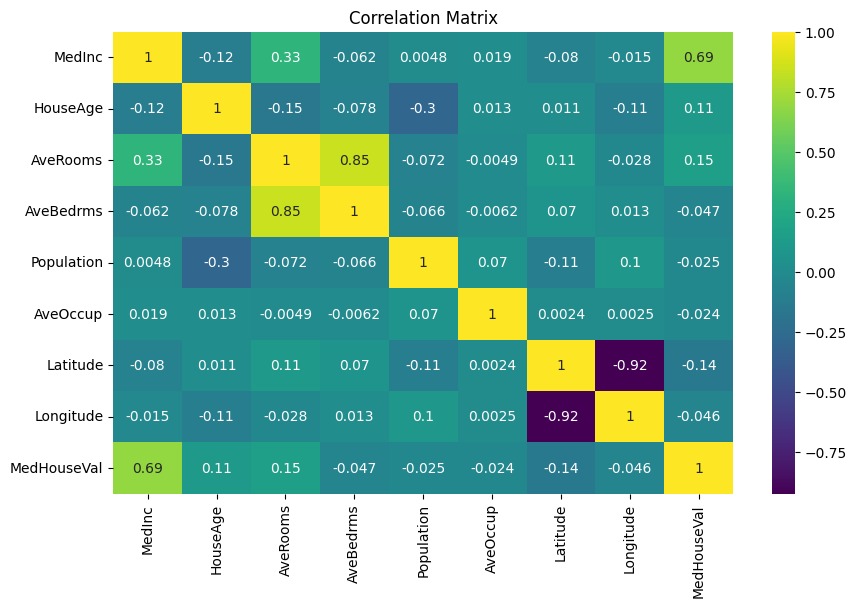

In [4]:
#checking for missing values and EDA (exploratory data analysis)

print("number of null values in the dataset:\n",df.isnull().sum())
print("Number of na values in the dataset:\n",df.isna().sum())


# checking histogram of the dataset

sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of Median hoouse Values")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True,cmap='viridis')
plt.title("Correlation Matrix")
plt.show()



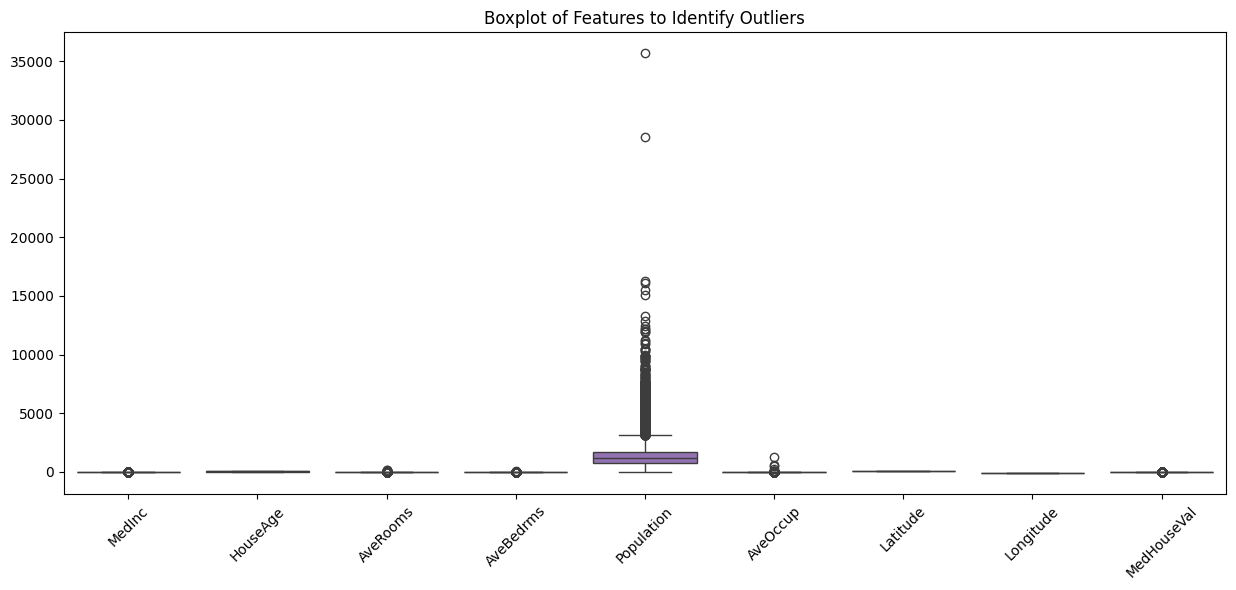

Dataset size after outlier removal: (18869, 9)


In [5]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot of Features to Identify Outliers")
plt.show()


# removing outliers from the dataset

# Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply to key features
columns_to_check = ["MedInc", "AveRooms", "AveOccup"]
for col in columns_to_check:
    df = remove_outliers(df, col)

print("Dataset size after outlier removal:", df.shape)


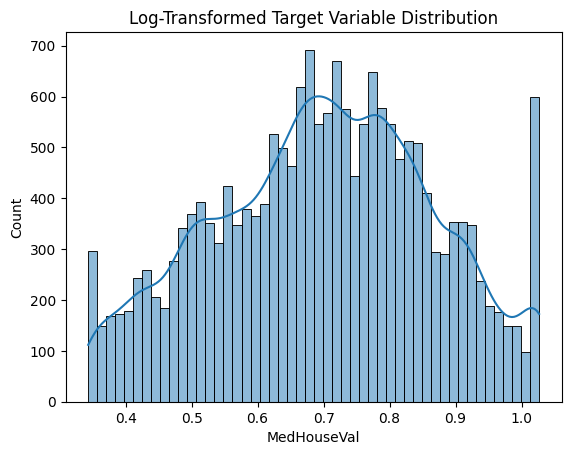

In [10]:
# removing the outlier in the target variable using log transformation

df['MedHouseVal'] = np.log1p(df['MedHouseVal'])
sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Log-Transformed Target Variable Distribution")
plt.show()

# removing outliers from the target variable through capping the extreme values (Winorization)

lower_bound = np.percentile(df['MedHouseVal'], 1)
upper_bound = np.percentile(df['MedHouseVal'], 99)

df['MedHouseVal'] = np.where(df['MedHouseVal'] > upper_bound, upper_bound, df['MedHouseVal'])
df['MedHouseVal'] = np.where(df['MedHouseVal'] < lower_bound, lower_bound, df['MedHouseVal'])

df = df[(df['MedHouseVal'] >= lower_bound) & (df['MedHouseVal'] <= upper_bound)]

plt.show()

# Feature Engineering Enhancements Adding new features

df['Bedrmsperrm'] = df['AveBedrms'] / df['AveRooms']
df['AveRoomsPerHouse'] = df['AveRooms'] / df['AveOccup']
df['AvePopPerHouse'] = df['Population'] / df['AveOccup']


In [14]:
# Feature Engineering

# Selecting features based on correlation
num_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude','Bedrmsperrm','AveRoomsPerHouse','AvePopPerHouse']  # Removed 'Population' & 'AveOccup'

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
])


X = df.drop(columns=['MedHouseVal','Population','AveOccup'])
y = df['MedHouseVal']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  


In [15]:
# training the model

mlflow.start_run()

''' hypertunning the model using optuna 
    Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning.
    It features an imperative, define-by-run style user API.
    Optuna is a framework to optimize hyperparameters of machine learning models.
    Optuna is a hyperparameter optimization framework applicable to machine learning frameworks and black-box optimization solvers.
    It is a Python library that is used to tune hyperparameters of machine learning models.'''

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best parameters:", best_params)

# Train baseline model
baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

mlflow.log_param("model_type_baseline", "Baseline RandomForest")
mlflow.log_param("features_used_baseline", num_features)

baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate
r2_baseline = r2_score(y_test, y_pred_baseline)
mlflow.log_metrics({"MAE":mean_absolute_error(y_test, y_pred_baseline),
                   "RMSE":mean_squared_error(y_test, y_pred_baseline),
                   "R² Score":r2_score(y_test, y_pred_baseline)})

model_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)    # Predictions


# Training XGBoost model
model_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42))
])

model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)   
 # Predictions
mlflow.log_param("model_type_xgboost", "XGBoost")
mlflow.log_param("features_used_xgboost", num_features) # Log features used
mlflow.log_metrics({"XGB_R² Score":r2_score(y_test, y_pred_xgb),
                   "XGB_MAE":mean_absolute_error(y_test, y_pred_xgb),
                   "XGB_RMSE":mean_squared_error(y_test, y_pred_xgb)}) # Log RMSE

[I 2025-03-12 22:23:18,776] A new study created in memory with name: no-name-a1ebc0a1-cd40-4600-a406-0c5d033269ff
C:\Users\Yaswanth\AppData\Local\Temp\ipykernel_21020\3199337277.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Yaswanth\AppData\Local\Temp\ipykernel_21020\3199337277.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\Yaswanth\AppData\Local\Temp\ipykernel_21020\3199337277.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases

Best parameters: {'n_estimators': 443, 'max_depth': 12, 'learning_rate': 0.015706126663815892, 'subsample': 0.7077961268300312, 'colsample_bytree': 0.91815638016249}


In [16]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}  

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params_grid = grid_search.best_params_
best_model_grid = grid_search.best_estimator_
best_r2_grid = grid_search.best_score_

# training the model with the best parameters got from the optuna
best_xgb_model = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=0.1,  # L1 regularization (Lasso)
    reg_lambda=0.5  # L2 regularization (Ridge)
)

best_xgb_model.fit(X_train, y_train)

y_pred_xgb_best = best_xgb_model.predict(X_test)

# printing the optuna model metrics
print("XGBoost - optuna- MAE:", mean_absolute_error(y_test, y_pred_xgb_best))
print("XGBoost - optuna- RMSE:", mean_squared_error(y_test, y_pred_xgb_best))
print("XGBoost - optuna- R² Score:", r2_score(y_test, y_pred_xgb_best))

mlflow.log_param("best_params_optuna", best_params)
mlflow.log_metrics({"XGBoost-optuna-R2_Score":r2_score(y_test, y_pred_xgb_best),
                   "XGBoost-optuna-MAE":mean_absolute_error(y_test, y_pred_xgb_best),
                   "XGBoost-optuna-RMSE":mean_squared_error(y_test, y_pred_xgb_best)})


# Stacking model
stacked_model = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=200, max_depth=20)),
        ('ridge', Ridge(alpha=1.0)),
        ('xgb', xgb.XGBRegressor(n_estimators=200, max_depth=10))
    ],
    final_estimator=xgb.XGBRegressor(n_estimators=100, max_depth=5)  # Meta model
)

stacked_model.fit(X_train, y_train)
y_pred_stack = stacked_model.predict(X_test)

# printing the Stack model metrics
print("Stacked Model R² Score:", r2_score(y_test, y_pred_stack))
print(f"Baseline Model R² Score: {r2_baseline}")

# printing the Baseline model and XGBoost model metrics
print("MAE:", mean_absolute_error(y_test, y_pred_baseline))  
print("RMSE:", mean_squared_error(y_test, y_pred_baseline))  
print("R² Score:", r2_score(y_test, y_pred_baseline))

# printing the Gradient Boosting model metrics
print("XGBoost - MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBoost - RMSE:", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost - R² Score:", r2_score(y_test, y_pred_xgb))

mlflow.end_run()
# Save best model
joblib.dump(best_xgb_model, "best_house_price_model.pkl")


XGBoost - optuna- MAE: 0.0432204181712586
XGBoost - optuna- RMSE: 0.003915776303731843
XGBoost - optuna- R² Score: 0.8618836211145946
Stacked Model R² Score: 0.8426859990471771
Baseline Model R² Score: 0.8444804638393265
MAE: 0.045830426187879095
RMSE: 0.004409178110371694
R² Score: 0.8444804638393265
XGBoost - MAE: 0.04615009578970459
XGBoost - RMSE: 0.004274562759212156
XGBoost - R² Score: 0.8492285861533676


['best_house_price_model.pkl']